In [1]:
import os
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
import numpy as np
from autocorrect import Speller
from googletrans import Translator
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics.pairwise import pairwise_distances

from collections import Counter
import scipy
from scipy.spatial.distance import pdist, squareform
import sys
os.getcwd()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vahid\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vahid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'C:\\Users\\Vahid\\OneDrive - University of Toronto\\MMA - 2022 -\\Jupyter files\\BigBasket'

In [44]:
#path = '/Users/Vahid/Library/CloudStorage/OneDrive-UniversityofToronto/MMA - 2022 -/Jupyter files/Data/'
path = 'C:\\Users\\Vahid\\OneDrive - University of Toronto\\MMA - 2022 -\\Jupyter files\\Data\\'
df_raw = pd.read_excel(path+'IMB575-XLS-ENG.xls', sheet_name ='POS DATA' )
df_raw = df_raw [~ df_raw['Description'].isin(['CFLs,cfls,7832553,2,0\r\n7831582,Channa Dal,channa-dal,7832491,2,0\r\n7832360,Cheese,cheese,7832363,2,0\r\n7831689,Chewing Gum,chewing-gum,7831685,2,0\r\n7832047,ChildrenS Books'])]

In [45]:
df_raw.columns

Index(['Member', 'Order', 'SKU', 'Created On', 'Description'], dtype='object')

# Q1. Identify the top ten popular items among all baskets.

In [46]:
summary = df_raw.groupby('Description')['Order'].agg('nunique').reset_index().rename(columns = {'Order': '# Orders'})
summary = summary.sort_values(by='# Orders',ascending=False)

#showing only top 10 popular items
summary.iloc[0:10,]

,Description,# Orders
151,Other Vegetables,3588
173,Root Vegetables,3473
15,Beans,3347
80,Gourd & Cucumber,2519
24,Brinjals,2285
12,Banana,2183
137,Other Dals,1952
212,Whole Spices,1709
131,Organic F&V,1415
189,Sugar,1337


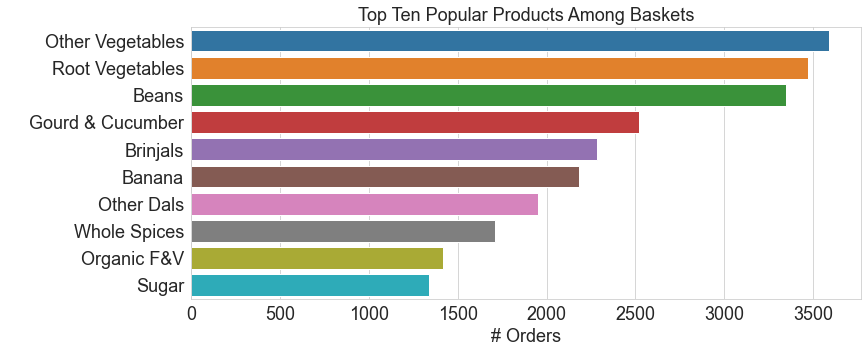

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.set_style("whitegrid")

sns.barplot(y='Description', x='# Orders', data=summary.iloc[0:10,])
plt.title('Top Ten Popular Products Among Baskets', fontsize=18)
plt.ylabel(' ', fontsize=18)
plt.xlabel('# Orders', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Q2. Identify the busiest time of the day



      Number_orders
time               
0               171
1                64
2                37
3                14
4                 7


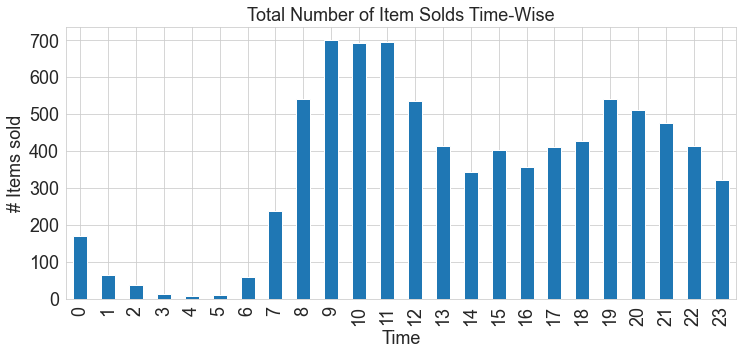

In [48]:
## Number of unique baskets 
df_raw['Created On'] = pd.to_datetime(df_raw['Created On'])

df_raw['date'] = df_raw['Created On'].dt.date
df_raw['time'] = df_raw['Created On'].dt.hour

summary_time = df_raw.groupby('time').agg(Number_orders=('Order', 'nunique'))
print(summary_time.head())


fig, ax = plt.subplots(figsize=(12, 5))
sns.set_style("whitegrid")

summary_time['Number_orders'].plot(kind="bar",ax=ax)
plt.title('Total Number of Item Solds Time-Wise', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.ylabel('# Items sold', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Q3: Identify the busiest day of the week

In [70]:
df_raw['day'] = df_raw['Created On'].dt.day_name()
summary_day = df_raw.groupby(['day']).agg(Number_orders=('Order', 'nunique'))
summary_day.head()

,Number_orders
day,
Friday,1291
Monday,1104
Saturday,1329
Sunday,1193
Thursday,1169


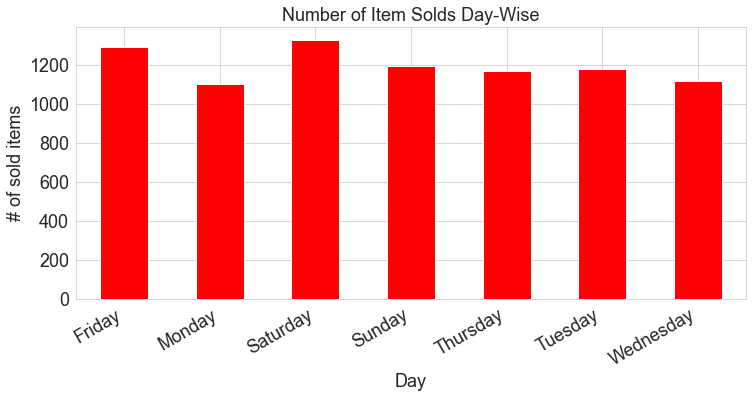

In [71]:
fig, ax = plt.subplots(figsize=(12, 5))

summary_day['Number_orders'].plot(kind="bar",color='red',ax=ax)
plt.title('Number of Item Solds Day-Wise', fontsize=18)
plt.xticks(rotation=30, ha='right', fontsize=18)
plt.xlabel('Day', fontsize=18)
plt.ylabel('# of sold items', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Q4. Identify the busiest season of the year

In [24]:
def get_season(x):
    if (x.month, x.day) < (3,20) or (x.month, x.day) > (12,20): 
        return 'winter'
    elif (x.month,x.day) < (6,21): 
        return 'spring'
    elif (x.month,x.day) < (9,23):     
        return 'summer'
    else: return 'fall'

In [25]:
df_raw['season'] = pd.to_datetime(df_raw['Created On']).apply(get_season)
summary_season = df_raw.groupby(['season']).agg(Number_orders=('Order', 'nunique'))
summary_season.head()

,Number_orders
season,
fall,1856
spring,2163
summer,2437
winter,1930


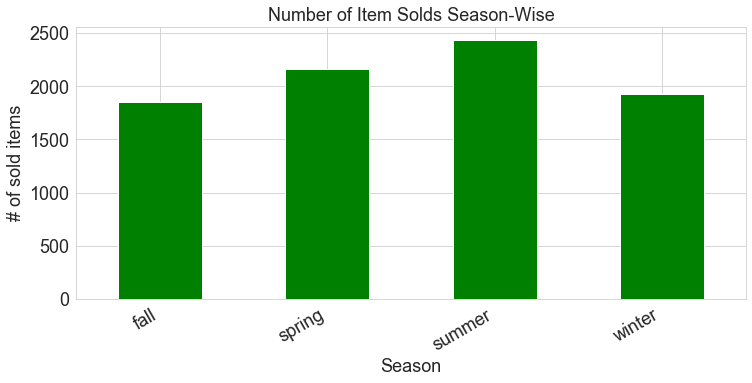

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

summary_season['Number_orders'].plot(kind="bar",color='green',ax=ax)
plt.title('Number of Item Solds Season-Wise', fontsize=18)
plt.xticks(rotation=30, ha='right', fontsize=18)
plt.xlabel('Season', fontsize=18)
plt.ylabel('# of sold items', fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.show()

# Q5. Create a smart basket for a customer with Member ID = M36432. Assume that he does not carry any items in his basket. (use Apriori algorithm with minimum support at  .1 and minimum lift at 1 and collected orders from the same member i.e., ID= M36432 )

In [72]:
def encode_u(x):
  if x < 1:
    return 0
  else:
    return 1


df_M36432 = df_raw[df_raw['Member'] == 'M36432']

basket_M36432 = (df_M36432.groupby(['Order', 'Description'])['Description'].size().unstack().reset_index().fillna(0).set_index('Order'))

basket_M36432 = basket_M36432.applymap(encode_u)
basket_M36432.head(5)

Description,Agarbatti,Almonds,Aluminium Foil & Cling Wrap,Avalakki / Poha,Bakery & Breads,Banana,Beans,Besan,Boiled Rice,Bread,...,Snacky Nuts,Sooji & Rava,Sugar,Sugar Cubes,Sunflower Oils,Toor Dal,Urad Dal,Veg & Fruit,Vermicelli,Whole Spices
Order,,,,,,,,,,,,,,,,,,,,,
6424887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6429696,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6429758,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6445388,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
6472456,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### List of items in the same memeber baskets with atleast .1 support 

In [73]:
frequentitemsets = apriori(basket_M36432, min_support=.1, use_colnames=True)
frequentitemsets.sort_values(by='support',ascending=False)

C:\Users\Vahid\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
6,0.301980,(Gourd & Cucumber)
10,0.262376,(Other Vegetables)
13,0.212871,(Whole Spices)
8,0.202970,(Organic F&V)
1,0.202970,(Banana)
9,0.198020,(Other Dals)
2,0.193069,(Beans)
0,0.183168,(Avalakki / Poha)
3,0.183168,(Brinjals)
18,0.153465,"(Gourd & Cucumber, Other Vegetables)"


In [75]:
prod_list = set()
for x in frequentitemsets['itemsets'].unique():
    prod_list.update(set(x))
prod_list

{'Avalakki / Poha',
 'Banana',
 'Beans',
 'Brinjals',
 'Cashews',
 'Exotic Vegetables',
 'Gourd & Cucumber',
 'Namkeen',
 'Organic F&V',
 'Other Dals',
 'Other Vegetables',
 'Root Vegetables',
 'Sooji & Rava',
 'Whole Spices'}

In [76]:
print('Please select from the following items : ', prod_list )

Please select from the following items :  {'Sooji & Rava', 'Other Vegetables', 'Avalakki / Poha', 'Organic F&V', 'Gourd & Cucumber', 'Cashews', 'Brinjals', 'Exotic Vegetables', 'Namkeen', 'Banana', 'Whole Spices', 'Beans', 'Root Vegetables', 'Other Dals'}


# Q6. Let’s assume order = 6468572 is your target basket. How Cosine Similarity can be used to create a ‘Did you forget?’ feature for this order?  ( use only the top three similar orders )

In [77]:
basket = df_raw.groupby(['Order', 'Description'])['Description'].size().unstack().reset_index().fillna(0).set_index('Order')
basket = basket.applymap(encode_u)
basket.head()

Description,After Shave,Agarbatti,Almonds,Aluminium Foil & Cling Wrap,Antiseptics,Avalakki / Poha,Ayurvedic,Ayurvedic Food,Baby Care Accessories,Baby Cereal,...,Vanaspati,Veg & Fruit,Vermicelli,Vinegar,Wafers,Washing Bars,Whole Grains,Whole Spices,Womens Deo,Yogurt & Lassi
Order,,,,,,,,,,,,,,,,,,,,,
6422558,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6422636,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6423338,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6423534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6423959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Cosine Similarity Matrix

In [78]:
cosine_sim = 1-pairwise_distances(basket,metric='cosine')
cosine_sim = pd.DataFrame(cosine_sim)

cosine_sim.index=basket.index
cosine_sim.columns=basket.index
cosine_sim.head()


Order,6422558,6422636,6423338,6423534,6423959,6424341,6424438,6424740,6424814,6424887,...,8387326,8387526,8387762,8387851,8387853,8387964,8387967,8388196,8388442,8388492
Order,,,,,,,,,,,,,,,,,,,,,
6422558,1.000000,0.119523,0.119523,0.0,0.000000,0.000000,0.000000,0.292770,0.218218,0.0,...,0.133631,0.000000,0.169031,0.000000,0.000000,0.218218,0.188982,0.285714,0.109109,0.478091
6422636,0.119523,1.000000,0.200000,0.0,0.316228,0.565685,0.316228,0.571548,0.182574,0.0,...,0.670820,0.424264,0.282843,0.182574,0.158114,0.182574,0.474342,0.358569,0.456435,0.400000
6423338,0.119523,0.200000,1.000000,0.0,0.000000,0.141421,0.000000,0.163299,0.182574,0.0,...,0.111803,0.141421,0.141421,0.000000,0.316228,0.000000,0.158114,0.358569,0.091287,0.100000
6423534,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.223607,0.000000,0.000000,0.288675,0.000000,0.000000,0.000000,0.000000
6423959,0.000000,0.316228,0.000000,0.0,1.000000,0.000000,0.000000,0.129099,0.000000,0.0,...,0.000000,0.223607,0.223607,0.577350,0.250000,0.000000,0.000000,0.188982,0.144338,0.316228


### Select target order and look into items in it 

In [79]:
order_id = 6468572
# List of item in target order
Item_target_basket = set(df_raw[df_raw['Order']==order_id]['Description'])
Item_target_basket

{'Banana',
 'Cashews',
 'Namkeen',
 'Other Dals',
 'Other Rice Products',
 'Other Sauces',
 'Other Sweets',
 'Sugar',
 'Sugar Cubes'}

## Identify top 4 similar baskets to target order

In [80]:
cosine_sim.iloc[cosine_sim.index == order_id,]

Order,6422558,6422636,6423338,6423534,6423959,6424341,6424438,6424740,6424814,6424887,...,8387326,8387526,8387762,8387851,8387853,8387964,8387967,8388196,8388442,8388492
Order,,,,,,,,,,,,,,,,,,,,,
6468572,0.251976,0.105409,0.210819,0.0,0.5,0.0,0.0,0.172133,0.19245,0.0,...,0.0,0.149071,0.298142,0.3849,0.166667,0.19245,0.166667,0.125988,0.096225,0.210819


In [81]:
cosine_similair_baskets = cosine_sim.iloc[cosine_sim.index == order_id,].T
cosine_similair_baskets.columns=['Cosine_similarity']
cosine_similair_baskets.sort_values(by='Cosine_similarity',ascending=False,inplace=True)
cosine_similair_baskets.head()

,Cosine_similarity
Order,
6468572,1.000000
6687487,0.596285
6549521,0.596285
7897662,0.577350
6704782,0.555556


In [82]:
cosine_similair_baskets = pd.merge(cosine_similair_baskets, basket,left_index=True, right_index=True)
cosine_similair_baskets.head()

,Cosine_similarity,After Shave,Agarbatti,Almonds,Aluminium Foil & Cling Wrap,Antiseptics,Avalakki / Poha,Ayurvedic,Ayurvedic Food,Baby Care Accessories,...,Vanaspati,Veg & Fruit,Vermicelli,Vinegar,Wafers,Washing Bars,Whole Grains,Whole Spices,Womens Deo,Yogurt & Lassi
Order,,,,,,,,,,,,,,,,,,,,,
6468572,1.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6687487,0.596285,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6549521,0.596285,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7897662,0.577350,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6704782,0.555556,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
# Top three similar baskets
Top_three_similar_baskets = cosine_similair_baskets.index[1:4]
Top_three_similar_baskets

Int64Index([6687487, 6549521, 7897662], dtype='int64', name='Order')

### Items in the  top 4 similar baskets 

In [84]:
# Item in top three similar basket 
Item_top_three_similar_basket = set(df_raw[df_raw['Order'].isin(Top_three_similar_baskets)]['Description'])
Item_top_three_similar_basket

{'Banana',
 'Cashews',
 'Cookies',
 'Namkeen',
 'Other Dals',
 'Other Rice Products',
 'Other Sauces',
 'Raw Peanuts',
 'Sugar',
 'Sugar Cubes'}

## Find disjoint between target basket and top three simialr basket

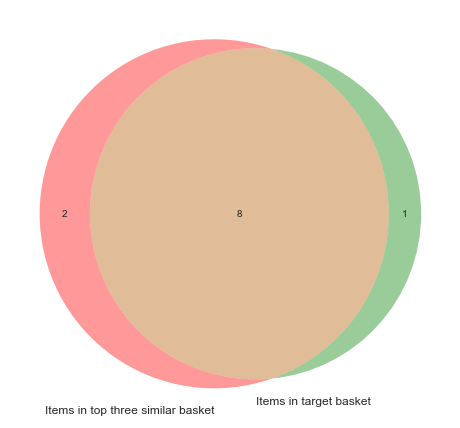

In [85]:
from matplotlib_venn import venn2
plt.figure(figsize=(8,8))
venn2([Item_top_three_similar_basket, Item_target_basket], ('Items in top three similar basket', 'Items in target basket'))
plt.show()

In [86]:
print('Did you forget? ' , Item_top_three_similar_basket.difference(Item_target_basket))

Did you forget?  {'Cookies', 'Raw Peanuts'}


# Q7. We are looking to create a 'Did you forget?' feature using the Dice coefficient between products. For order = 6468572, what other products may be missing?  (use only the top three similar products)

### Dice Coefficient applied to each product in the basket

In [87]:
a = pdist(basket.T, metric='dice')
Dice_sim_prod = pd.DataFrame(1-squareform(a))
Dice_sim_prod.columns= basket.columns
Dice_sim_prod.index=basket.columns
Dice_sim_prod.head()

Description,After Shave,Agarbatti,Almonds,Aluminium Foil & Cling Wrap,Antiseptics,Avalakki / Poha,Ayurvedic,Ayurvedic Food,Baby Care Accessories,Baby Cereal,...,Vanaspati,Veg & Fruit,Vermicelli,Vinegar,Wafers,Washing Bars,Whole Grains,Whole Spices,Womens Deo,Yogurt & Lassi
Description,,,,,,,,,,,,,,,,,,,,,
After Shave,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.000000,0.0,0.000000
Agarbatti,0.0,1.000000,0.016949,0.019512,0.0,0.033520,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.024733,0.0,0.006601
Almonds,0.0,0.016949,1.000000,0.036641,0.0,0.109777,0.003759,0.0,0.0,0.003831,...,0.0,0.007117,0.016129,0.011070,0.014493,0.007421,0.006920,0.149843,0.0,0.050465
Aluminium Foil & Cling Wrap,0.0,0.019512,0.036641,1.000000,0.0,0.023047,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.025532,0.000000,0.011976,0.000000,0.010363,0.030369,0.0,0.054348
Antiseptics,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.068966,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [88]:
Dice_sim_prod.shape

(215, 215)

### Identify items in the target basket

In [89]:
order_id = 6468572
# List of item in target order
Item_target_basket = set(df_raw[df_raw['Order']==order_id]['Description'])
Item_target_basket

{'Banana',
 'Cashews',
 'Namkeen',
 'Other Dals',
 'Other Rice Products',
 'Other Sauces',
 'Other Sweets',
 'Sugar',
 'Sugar Cubes'}

In [90]:
len(Item_target_basket)

9

### Dice Coefficient of products already in the target basket

In [91]:
target_basket_prod_index = Dice_sim_prod.index[np.where(Dice_sim_prod.index.isin(Item_target_basket))]
product_similiaty_target = Dice_sim_prod[target_basket_prod_index]
product_similiaty_target

Description,Banana,Cashews,Namkeen,Other Dals,Other Rice Products,Other Sauces,Other Sweets,Sugar,Sugar Cubes
Description,,,,,,,,,
After Shave,0.000915,0.000000,0.000000,0.000000,0.003356,0.000000,0.000000,0.000000,0.000000
Agarbatti,0.017754,0.033841,0.023130,0.018793,0.030120,0.016000,0.033195,0.022743,0.033613
Almonds,0.119127,0.349664,0.109903,0.148058,0.087971,0.010435,0.020260,0.105547,0.035149
Aluminium Foil & Cling Wrap,0.032787,0.042683,0.041116,0.045999,0.016461,0.010526,0.006536,0.033967,0.000000
Antiseptics,0.000913,0.000000,0.004862,0.003063,0.000000,0.000000,0.000000,0.002976,0.000000
...,...,...,...,...,...,...,...,...,...
Washing Bars,0.005450,0.011111,0.011236,0.005074,0.013051,0.000000,0.000000,0.008850,0.117647
Whole Grains,0.015172,0.013817,0.014008,0.012935,0.046012,0.000000,0.017467,0.012903,0.018692
Whole Spices,0.214286,0.157848,0.196866,0.363289,0.196266,0.021542,0.040426,0.297439,0.020478


In [92]:
product_similiaty_target.shape

(215, 9)

### Exclude products which are already in the baskets

In [98]:
product_similiaty_out_of_basket = product_similiaty_target.loc[~product_similiaty_target.index.isin(product_similiaty_target.columns),:]
product_similiaty_out_of_basket.head()

Description,Banana,Cashews,Namkeen,Other Dals,Other Rice Products,Other Sauces,Other Sweets,Sugar,Sugar Cubes
Description,,,,,,,,,
After Shave,0.000915,0.000000,0.000000,0.000000,0.003356,0.000000,0.000000,0.000000,0.000000
Agarbatti,0.017754,0.033841,0.023130,0.018793,0.030120,0.016000,0.033195,0.022743,0.033613
Almonds,0.119127,0.349664,0.109903,0.148058,0.087971,0.010435,0.020260,0.105547,0.035149
Aluminium Foil & Cling Wrap,0.032787,0.042683,0.041116,0.045999,0.016461,0.010526,0.006536,0.033967,0.000000
Antiseptics,0.000913,0.000000,0.004862,0.003063,0.000000,0.000000,0.000000,0.002976,0.000000


In [99]:
product_similiaty_out_of_basket.shape

(206, 9)

### Method 1. Maximum sum of Dice coefficient for out of basket products

In [100]:
# row sum of product_similiaty_out_of_basket and sort them from the highest to the lowest 
product_similiaty_out_of_basket['sum_dice_coff'] =  product_similiaty_out_of_basket.sum(axis=1)
#sum_similarity = product_similiaty_out_of_basket.sum(axis=1).sort_values(ascending=False)[0:3]
product_similiaty_out_of_basket.sort_values(by='sum_dice_coff',inplace=True,ascending=False)

C:\Users\Vahid\AppData\Local\Temp\ipykernel_21348\842326459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_similiaty_out_of_basket['sum_dice_coff'] =  product_similiaty_out_of_basket.sum(axis=1)
C:\Users\Vahid\AppData\Local\Temp\ipykernel_21348\842326459.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_similiaty_out_of_basket.sort_values(by='sum_dice_coff',inplace=True,ascending=False)


In [101]:
product_similiaty_out_of_basket.head()

Description,Banana,Cashews,Namkeen,Other Dals,Other Rice Products,Other Sauces,Other Sweets,Sugar,Sugar Cubes,sum_dice_coff
Description,,,,,,,,,,
Toor Dal,0.202312,0.143493,0.171725,0.386497,0.219134,0.021021,0.052486,0.303749,0.019608,1.520026
Whole Spices,0.214286,0.157848,0.196866,0.363289,0.196266,0.021542,0.040426,0.297439,0.020478,1.508439
Root Vegetables,0.408062,0.116675,0.200851,0.317419,0.133760,0.013605,0.037870,0.233680,0.013629,1.475552
Beans,0.370344,0.109100,0.207696,0.329119,0.141588,0.009994,0.037521,0.245517,0.014134,1.465013
Other Vegetables,0.356611,0.104648,0.204777,0.340433,0.112386,0.013725,0.038308,0.238782,0.011548,1.421218


In [102]:
print('Did you forget?', set(product_similiaty_out_of_basket.index[0:3]))

Did you forget? {'Toor Dal', 'Root Vegetables', 'Whole Spices'}


### Method 2. Maximum similairty to each  products in the basket 

In [103]:
final_2 = pd.merge(product_similiaty_out_of_basket.idxmax(axis=0).rename('Close product'),
         product_similiaty_out_of_basket.max(axis=0).rename('Dice coefficient'),
         left_index=True,
         right_index=True)


final_2.sort_values(by='Dice coefficient',ascending=False,inplace=True)
final_2

,Close product,Dice coefficient
Description,,
sum_dice_coff,Toor Dal,1.520026
Other Dals,Moong Dal,0.420370
Banana,Root Vegetables,0.408062
Cashews,Almonds,0.349664
Sugar,Toor Dal,0.303749
Other Rice Products,Boiled Rice,0.264996
Namkeen,Snacky Nuts,0.229487
Sugar Cubes,Soya Products,0.142857
Other Sweets,Other Oils,0.094340


In [104]:
print('Did you forget?', set(final_2['Close product'][0:3]))

Did you forget? {'Toor Dal', 'Moong Dal', 'Root Vegetables'}
